In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras import layers 
from warnings import filterwarnings
filterwarnings('ignore')


In [2]:

# Define directories for images
data_with_mask_dir = 'archive (2)/data/with_mask'
data_without_mask_dir = 'archive (2)/data/without_mask'


In [3]:
# Load images and labels
images = []
labels = []

def load_images_from_folder(folder, label):
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (128, 128))  # Resize images to a fixed size
        images.append(img)
        labels.append(label)


In [4]:
load_images_from_folder(data_with_mask_dir, 1)  # 1 for with mask
load_images_from_folder(data_without_mask_dir, 0)  # 0 for without mask


In [5]:
# Convert lists to numpy arrays
X = np.array(images)
Y = np.array(labels)


In [6]:
# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [7]:
# Normalize pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dense, Dropout
num_of_classes = 2
model = Sequential([
    # Add convolutional layers
    Conv2D(32, (3, 3), activation='relu',  input_shape=(128,128,3)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    # Flatten the output from the convolutional layers
    Flatten(),

    # Add dense layers
    Dense(512, activation='relu'),
    Dropout(rate=0.3),
    BatchNormalization(),

    Dense(256, activation='relu'),
    Dropout(rate=0.3),
    BatchNormalization(),

    Dense(128, activation='relu'),
    Dropout(rate=0.3),
    BatchNormalization(),

    Dense(64, activation='relu'),
    Dropout(rate=0.3),

    # Output layer for binary classification
    Dense(2, activation='sigmoid')
])

# Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [9]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [11]:

# Train the model
history = model.fit(X_train, Y_train, epochs=2, validation_split=0.1)


Epoch 1/2
170/170 ━━━━━━━━━━━━━━━━━━━━ 139s 801ms/step - accuracy: 0.9380 - loss: 0.1632 - val_accuracy: 0.9620 - val_loss: 0.1067
Epoch 2/2
170/170 ━━━━━━━━━━━━━━━━━━━━ 110s 621ms/step - accuracy: 0.9377 - loss: 0.1691 - val_accuracy: 0.9570 - val_loss: 0.1068


In [12]:
model.save('face mask detection.keras')

In [13]:
model = load_model('face mask detection.keras')

In [14]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test)
print('Test Accuracy:', accuracy)


48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.8162 - loss: 0.4045
Test Accuracy: 0.8127068281173706


In [16]:
def predict_image(image_path, confidence_threshold=0.65):
    # Read the image from the file path
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or unable to read image file")

    # Resize the image to the required size
    img = cv2.resize(image, (128, 128))
    img = img / 255.0  # Normalize the image
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Predict the output
    prediction = model.predict(img)[0][0]

    # Check if the prediction confidence is high
    if prediction < (1 - confidence_threshold):
        return "With Mask"
    elif prediction > confidence_threshold:
        return "Without Mask"
    else:
        return "Cant Predict"


In [18]:
# Test the prediction function
image_path = 'with_mask_2.jpg'
print("Prediction for", image_path, ":", predict_image(image_path))

image_path = 'without_mask_3.jpg'
print("Prediction for", image_path, ":", predict_image(image_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction for with_mask_2.jpg : With Mask
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for without_mask_3.jpg : Without Mask


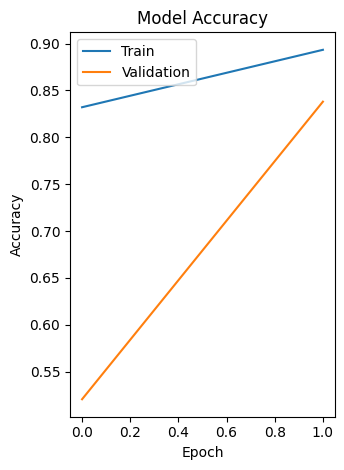

In [20]:
# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

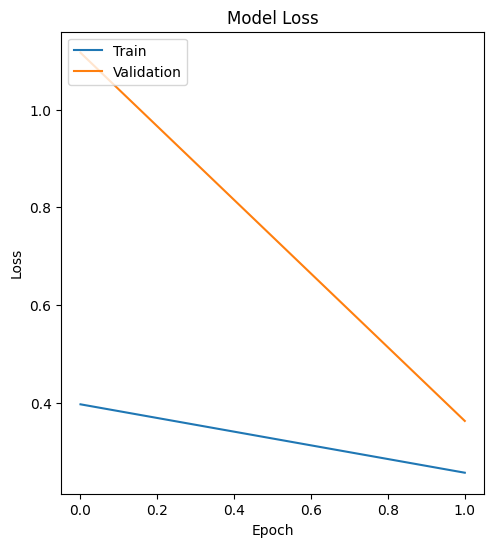

In [21]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')